# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band11.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.104861 -0.134601  0.161135  0.010023 -0.211455 -0.059656   
      201547 -0.054776 -0.084949 -0.085900 -0.494432 -1.000000 -0.632523   
      201548 -0.177701 -0.084825  0.254967  0.091757  0.402168 -0.144645   
      201549  0.014306  0.622665 -0.369653 -0.344733  0.186457  0.246245   
      201550  0.773525  0.179754 -0.404514  0.075534 -0.168979 -0.137839   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.135785 -0.220899 -0.136465 -0.133649  ... -0.002851  0.053162   
      201547 -0.033494  0.651654 -0.133243  0.334687  ...  0.280512 -0.200336   
      201548 -0.079466 -0.228686 -0.482965 -0.114217  ... -0.608325 -0.048135   
      201549  0.236825  0.200119  0.017916  0.079657  ... -0.729004  0.369721   
      201550  0.313409 -0.201862  0.205791 -0.236597  ... -0.211941 -0.375798   

                  1017      1018      1019      1020      1021      1022  \
41001 201546 -0.134165 -0.184506 -0.167012 -0.002746 -0.012365  0.114121   
      201547  0.466681 -0.768251 -0.054468 -0.743246  0.074160  0.056224   
      201548 -0.077311 -0.919810 -0.265093  0.045041 -0.097751  0.456597   
      201549 -0.491827 -0.124479  0.023940 -0.014327  0.109107 -0.165374   
      201550 -0.100686 -0.053689  0.249454 -0.018535 -0.183186 -0.204267   

                  1023    Labels  
41001 201546  0.429214 -0.861740  
      201547  0.093957 -0.854589  
      201548  0.314805 -0.856973  
      201549  0.472125 -0.856973  
      201550  0.177377 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820 -0.076048  0.192521 -0.111176 -0.092376  0.202677 -0.134957   
      201821  0.104735 -0.066218 -0.025078 -0.186354  0.118997  0.255450   
      201822  0.065257 -0.117963 -0.042926 -0.225352  0.060053  0.154271   
      201823 -0.185969  0.028047 -0.026724 -0.051019 -0.214967  0.469237   
      201824 -0.701491  0.338298 -0.077899  0.145443  0.285693 -0.597999   

                     6         7         8         9  ...      1015      1016  \
41001 201820  0.593301 -0.429148  0.318573  0.229561  ... -0.341576 -0.391819   
      201821  0.176656 -0.798130 -0.000158 -0.035053  ... -0.081461  0.499833   
      201822  0.837714 -0.044488 -0.050366 -0.061650  ...  0.042861  0.552237   
      201823  0.542341 -0.210211 -0.312560 -0.073773  ... -0.131928  0.087342   
      201824 -0.032099 -0.265799  0.076662  0.398716  ... -0.282144  0.457014   

                  1017      1018      1019      1020      1021      1022  \
41001 201820 -0.121492  0.034899 -0.131771 -0.699919 -0.486598  0.009076   
      201821 -0.514769  0.250767  0.411781  0.271846 -0.016814 -0.307397   
      201822  0.620309  0.085412  0.048077 -0.108034  0.119720 -0.337423   
      201823 -0.468429  0.060636 -0.514580  0.010996 -0.501910 -0.311488   
      201824  0.708065  0.387642 -0.300252 -0.092183  0.482541 -0.496719   

                  1023    Labels  
41001 201820  0.120093 -0.949940  
      201821  0.550715 -0.961859  
      201822 -0.424071 -0.940405  
      201823 -0.484744 -0.961859  
      201824  0.029114 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

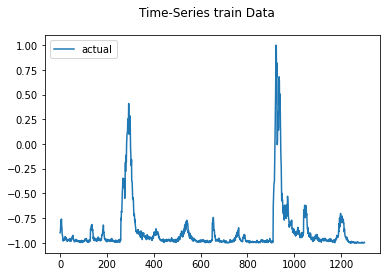

2023-03-14 15:36:54.700966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 15:36:54.701035: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 15:36:54.701070: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 15:36:54.701392: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 15:36:54.819454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 48.948
Test RMSE: 56.602
Test sMAPE: 105.142
Test R Squared: -2.315
{'mae': 48.947948996225996, 'rmse': 56.601507698115576, 'smape': 105.14169472089706, 'r2': -2.315110439149239}


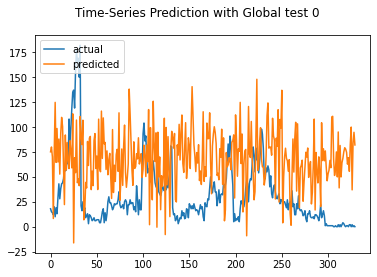

Test MAE: 41.936
Test RMSE: 51.834
Test sMAPE: 104.912
Test R Squared: -1.780
{'mae': 41.93567823334174, 'rmse': 51.83398243522789, 'smape': 104.91190036147411, 'r2': -1.7801687415988954}


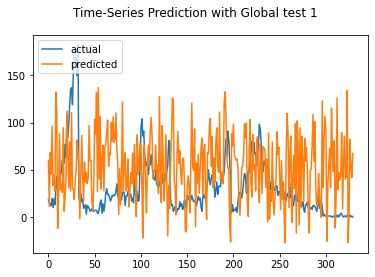

Test MAE: 38.946
Test RMSE: 49.717
Test sMAPE: 104.092
Test R Squared: -1.558
{'mae': 38.94631150166194, 'rmse': 49.716598243958835, 'smape': 104.0922654568053, 'r2': -1.5576717828994662}


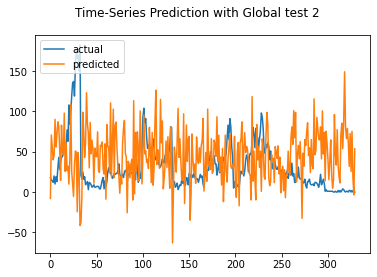

Test MAE: 39.482
Test RMSE: 48.017
Test sMAPE: 100.424
Test R Squared: -1.386
{'mae': 39.48243080630447, 'rmse': 48.01713269252496, 'smape': 100.42360690536738, 'r2': -1.3858022702535693}


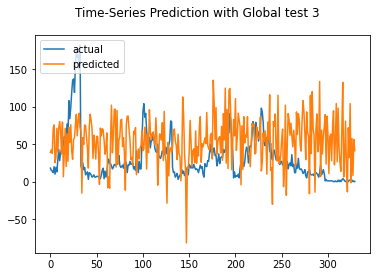

Test MAE: 40.351
Test RMSE: 50.397
Test sMAPE: 104.829
Test R Squared: -1.628
{'mae': 40.35100535660079, 'rmse': 50.396785214708295, 'smape': 104.82933935617652, 'r2': -1.6281349970421117}


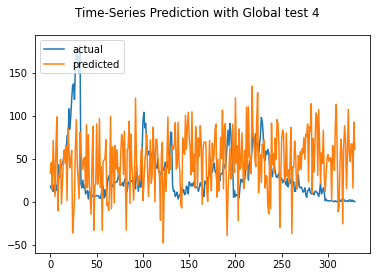

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 39.129
Test RMSE: 49.816
Test sMAPE: 118.518
Test R Squared: -1.568
{'mae': 39.129101343046536, 'rmse': 49.815563844432425, 'smape': 118.51763735368446, 'r2': -1.5678644937424933}


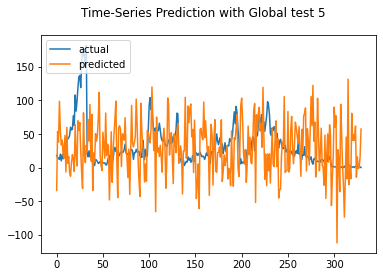

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 41.406
Test RMSE: 51.779
Test sMAPE: 110.843
Test R Squared: -1.774
{'mae': 41.40631031502377, 'rmse': 51.77931565022874, 'smape': 110.84261037268513, 'r2': -1.7743076159344047}


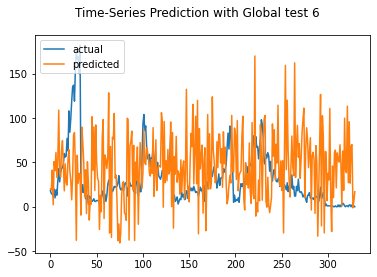

Test MAE: 51.251
Test RMSE: 59.664
Test sMAPE: 106.605
Test R Squared: -2.684
{'mae': 51.25074707504475, 'rmse': 59.66359245203267, 'smape': 106.60475414020306, 'r2': -2.683501072078372}


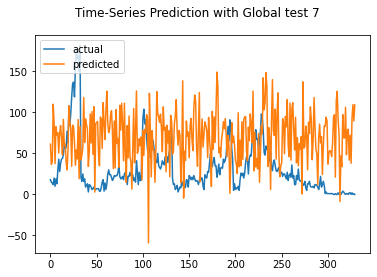

Test MAE: 45.819
Test RMSE: 54.353
Test sMAPE: 103.502
Test R Squared: -2.057
{'mae': 45.81936460191553, 'rmse': 54.35281566744486, 'smape': 103.50235320575534, 'r2': -2.056934234729556}


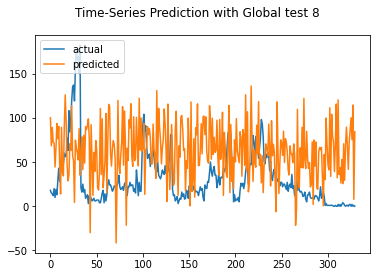

Test MAE: 52.049
Test RMSE: 64.280
Test sMAPE: 112.511
Test R Squared: -3.276
{'mae': 52.048604601621626, 'rmse': 64.28022754211716, 'smape': 112.51090662920036, 'r2': -3.275597480925713}


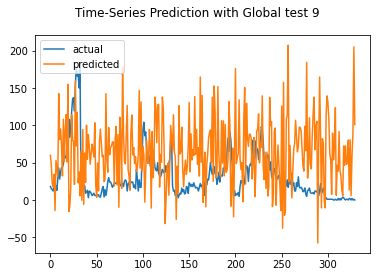

Test MAE: 50.915
Test RMSE: 60.152
Test sMAPE: 105.478
Test R Squared: -2.744
{'mae': 50.915405351104155, 'rmse': 60.15236514036264, 'smape': 105.47830335920307, 'r2': -2.744099812207319}


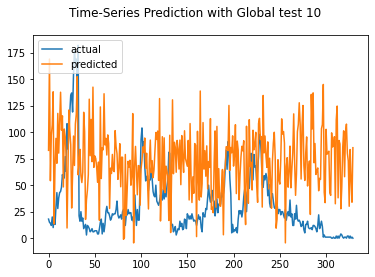

Test MAE: 54.737
Test RMSE: 63.596
Test sMAPE: 109.099
Test R Squared: -3.185
{'mae': 54.73650104096441, 'rmse': 63.59618932111243, 'smape': 109.09947073246967, 'r2': -3.1850840912664973}


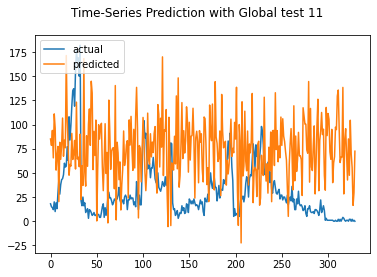

Test MAE: 50.827
Test RMSE: 59.950
Test sMAPE: 103.722
Test R Squared: -2.719
{'mae': 50.826774603670295, 'rmse': 59.950183022697914, 'smape': 103.72161844772138, 'r2': -2.718973024848761}


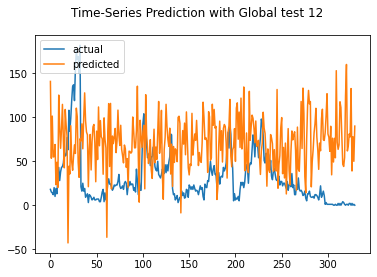

Test MAE: 46.417
Test RMSE: 55.680
Test sMAPE: 103.236
Test R Squared: -2.208
{'mae': 46.41732355970325, 'rmse': 55.68034187074096, 'smape': 103.23608334150993, 'r2': -2.2080844185070583}


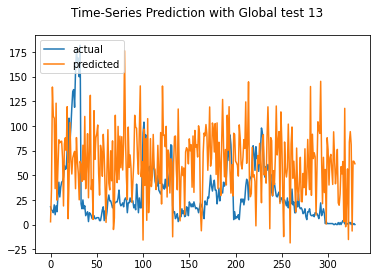

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 53.241
Test RMSE: 67.016
Test sMAPE: 112.256
Test R Squared: -3.647
{'mae': 53.241171939445266, 'rmse': 67.01614354284182, 'smape': 112.25612441577131, 'r2': -3.6473016941159893}


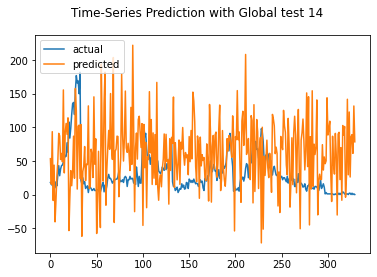

Test MAE: 42.524
Test RMSE: 51.527
Test sMAPE: 102.367
Test R Squared: -1.747
{'mae': 42.52390913042155, 'rmse': 51.5272633777864, 'smape': 102.36738397578658, 'r2': -1.7473637071741135}


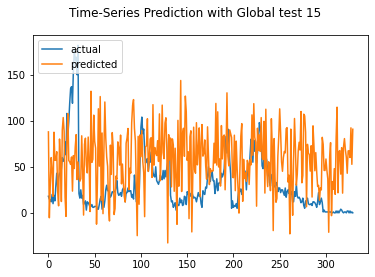

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 44.499
Test RMSE: 54.401
Test sMAPE: 114.175
Test R Squared: -2.062
{'mae': 44.49864555019321, 'rmse': 54.40093722248938, 'smape': 114.17497782676475, 'r2': -2.0623495769554165}


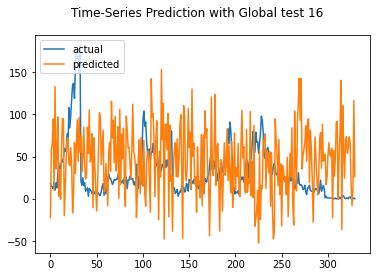

Test MAE: 40.634
Test RMSE: 50.613
Test sMAPE: 107.881
Test R Squared: -1.651
{'mae': 40.63355042464806, 'rmse': 50.612734514798944, 'smape': 107.88108297637902, 'r2': -1.6507062729026591}


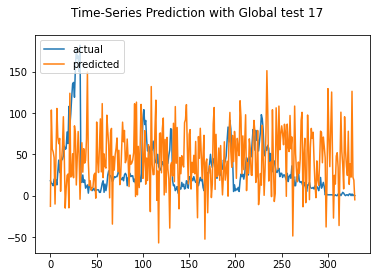

Test MAE: 47.213
Test RMSE: 55.049
Test sMAPE: 101.688
Test R Squared: -2.136
{'mae': 47.21251282186219, 'rmse': 55.04888527260987, 'smape': 101.68837401363108, 'r2': -2.135732879101938}


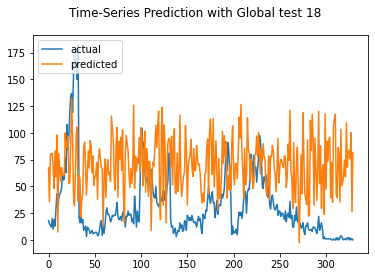

Test MAE: 31.077
Test RMSE: 42.021
Test sMAPE: 107.718
Test R Squared: -0.827
{'mae': 31.07694391066378, 'rmse': 42.02133929020453, 'smape': 107.71818262734966, 'r2': -0.827181887982436}


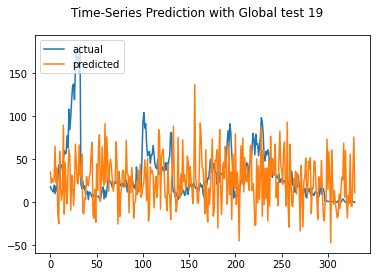

Test MAE: 62.203
Test RMSE: 70.065
Test sMAPE: 113.457
Test R Squared: -4.080
{'mae': 62.20313744689479, 'rmse': 70.06463893871282, 'smape': 113.4568845356587, 'r2': -4.0797200487133045}


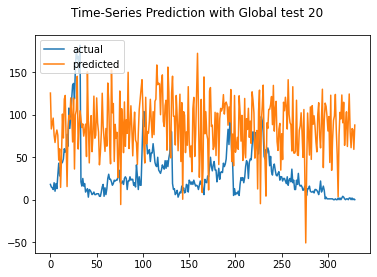

Test MAE: 36.177
Test RMSE: 44.811
Test sMAPE: 102.273
Test R Squared: -1.078
{'mae': 36.17736099235939, 'rmse': 44.8111379393814, 'smape': 102.2731516719196, 'r2': -1.0778488239383393}


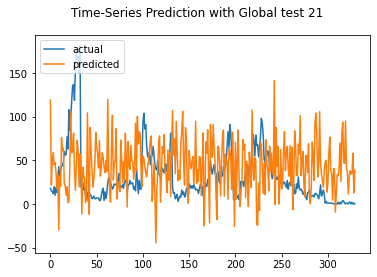

Test MAE: 41.841
Test RMSE: 52.372
Test sMAPE: 103.729
Test R Squared: -1.838
{'mae': 41.841040537754694, 'rmse': 52.37172057572633, 'smape': 103.72896561480285, 'r2': -1.838152228765447}


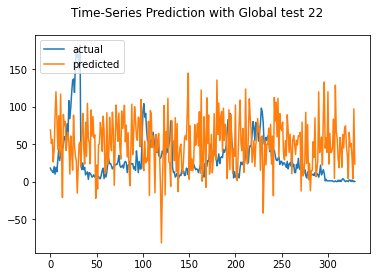

Test MAE: 46.478
Test RMSE: 55.801
Test sMAPE: 101.572
Test R Squared: -2.222
{'mae': 46.47814386324449, 'rmse': 55.80129320231138, 'smape': 101.57244337979031, 'r2': -2.22203704554302}


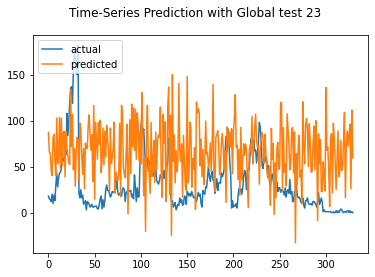

Test MAE: 41.849
Test RMSE: 51.227
Test sMAPE: 102.213
Test R Squared: -1.715
{'mae': 41.84947924740387, 'rmse': 51.22731342884495, 'smape': 102.21306139785213, 'r2': -1.715470957143609}


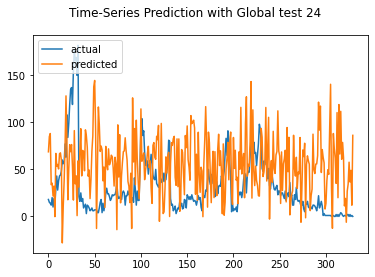

Test MAE: 44.087
Test RMSE: 52.781
Test sMAPE: 100.996
Test R Squared: -1.883
{'mae': 44.086597137017684, 'rmse': 52.781491950494605, 'smape': 100.99561420578203, 'r2': -1.8827390143586582}


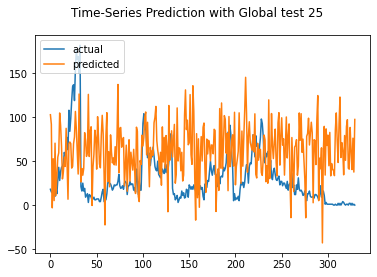

Test MAE: 35.738
Test RMSE: 46.093
Test sMAPE: 106.473
Test R Squared: -1.198
{'mae': 35.738112333868486, 'rmse': 46.09329818903119, 'smape': 106.47282189177812, 'r2': -1.1984549554208108}


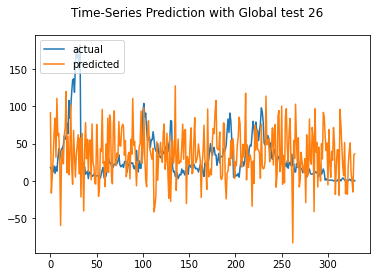

Test MAE: 38.316
Test RMSE: 46.826
Test sMAPE: 103.800
Test R Squared: -1.269
{'mae': 38.31614691723477, 'rmse': 46.825730915133974, 'smape': 103.80012456898152, 'r2': -1.2688779365996568}


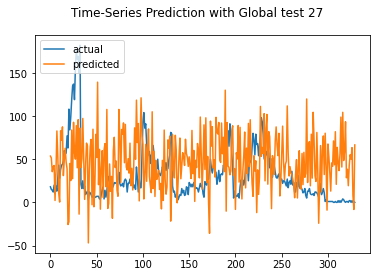

Test MAE: 32.084
Test RMSE: 41.162
Test sMAPE: 107.064
Test R Squared: -0.753
{'mae': 32.08423594254436, 'rmse': 41.16180555577708, 'smape': 107.06388487014011, 'r2': -0.7531974697158188}


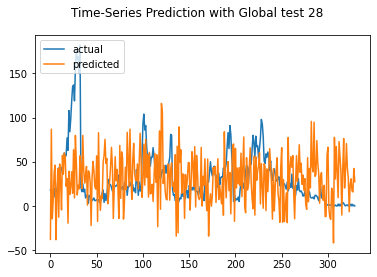

Test MAE: 44.219
Test RMSE: 53.637
Test sMAPE: 104.287
Test R Squared: -1.977
{'mae': 44.21874795167735, 'rmse': 53.63739477044698, 'smape': 104.28652807416621, 'r2': -1.9769898415008704}


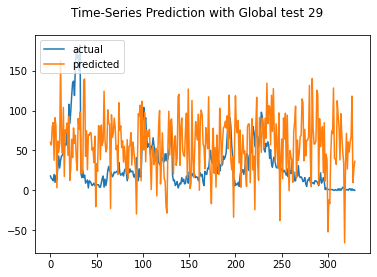

Test MAE: 46.078
Test RMSE: 54.336
Test sMAPE: 101.438
Test R Squared: -2.055
{'mae': 46.0784389194214, 'rmse': 54.33640874214539, 'smape': 101.438357121317, 'r2': -2.0550889826980563}


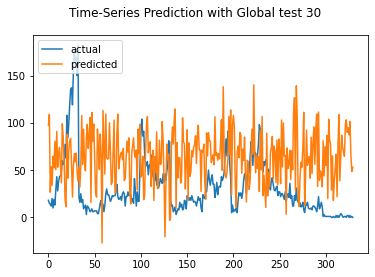

Test MAE: 46.792
Test RMSE: 57.351
Test sMAPE: 102.430
Test R Squared: -2.404
{'mae': 46.7924685716629, 'rmse': 57.35130316775199, 'smape': 102.42962362510985, 'r2': -2.4035221624974357}


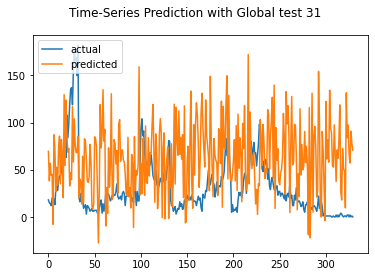

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 46.943
Test RMSE: 59.127
Test sMAPE: 112.301
Test R Squared: -2.617
{'mae': 46.94349648862174, 'rmse': 59.12663647170579, 'smape': 112.30092939071899, 'r2': -2.6174984172389477}


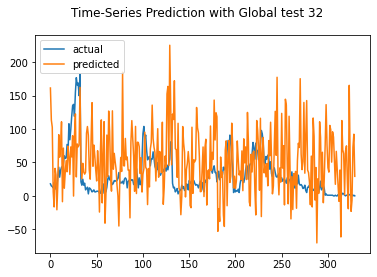

Test MAE: 43.088
Test RMSE: 53.292
Test sMAPE: 103.562
Test R Squared: -1.939
{'mae': 43.0875057534738, 'rmse': 53.291671580577095, 'smape': 103.56229318181691, 'r2': -1.9387367721426596}


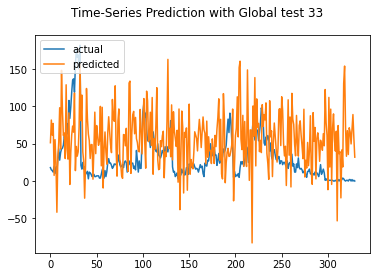

Test MAE: 50.147
Test RMSE: 59.062
Test sMAPE: 104.010
Test R Squared: -2.610
{'mae': 50.14666438463962, 'rmse': 59.06179548837056, 'smape': 104.01017400138481, 'r2': -2.6095685381602594}


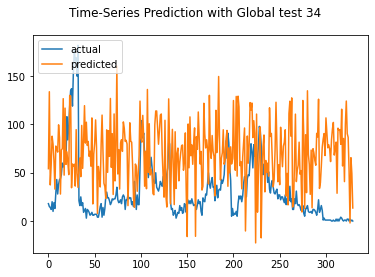

Test MAE: 40.323
Test RMSE: 49.893
Test sMAPE: 101.449
Test R Squared: -1.576
{'mae': 40.322554259950465, 'rmse': 49.89261899549449, 'smape': 101.44925986927905, 'r2': -1.5758146283004537}


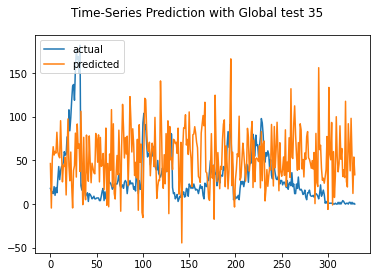

Test MAE: 33.900
Test RMSE: 44.693
Test sMAPE: 107.128
Test R Squared: -1.067
{'mae': 33.900075149897376, 'rmse': 44.693445092085845, 'smape': 107.12790110342583, 'r2': -1.0669485516925246}


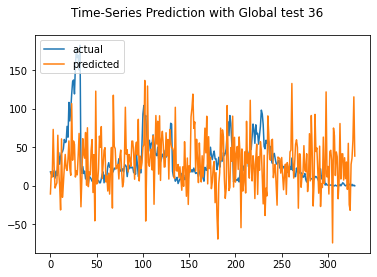

Test MAE: 35.298
Test RMSE: 44.118
Test sMAPE: 101.394
Test R Squared: -1.014
{'mae': 35.29760280287627, 'rmse': 44.11760664187292, 'smape': 101.39364537971525, 'r2': -1.014029789728356}


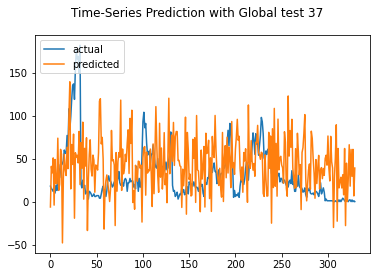

Test MAE: 45.041
Test RMSE: 54.149
Test sMAPE: 102.792
Test R Squared: -2.034
{'mae': 45.041255914081226, 'rmse': 54.14885620144607, 'smape': 102.79200422361808, 'r2': -2.0340349299161002}


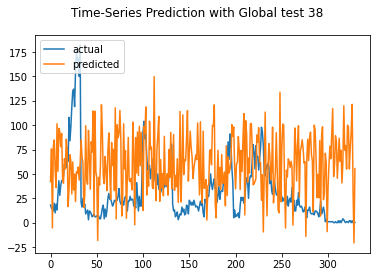

Test MAE: 50.397
Test RMSE: 60.175
Test sMAPE: 103.670
Test R Squared: -2.747
{'mae': 50.39717076646559, 'rmse': 60.17508088567996, 'smape': 103.6696224428511, 'r2': -2.7469281657254414}


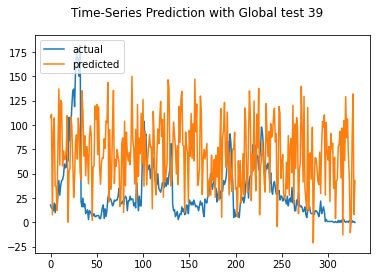

Test MAE: 60.243
Test RMSE: 68.245
Test sMAPE: 110.578
Test R Squared: -3.819
{'mae': 60.24290491017428, 'rmse': 68.24513877931085, 'smape': 110.57755168338701, 'r2': -3.8193164492751874}


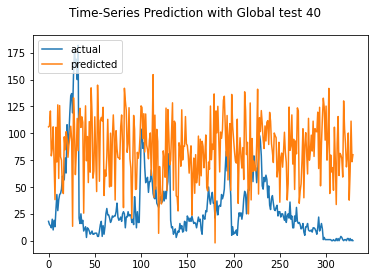

Test MAE: 49.146
Test RMSE: 58.806
Test sMAPE: 104.568
Test R Squared: -2.578
{'mae': 49.14617508577578, 'rmse': 58.80572227989018, 'smape': 104.56756057516318, 'r2': -2.5783365031883023}


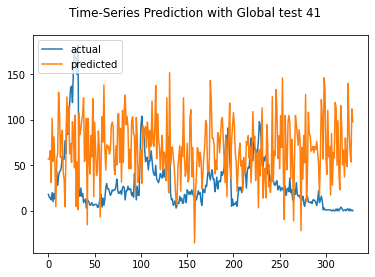

Test MAE: 38.875
Test RMSE: 48.499
Test sMAPE: 98.535
Test R Squared: -1.434
{'mae': 38.87546971169385, 'rmse': 48.499036411026715, 'smape': 98.5348709100996, 'r2': -1.4339307733964093}


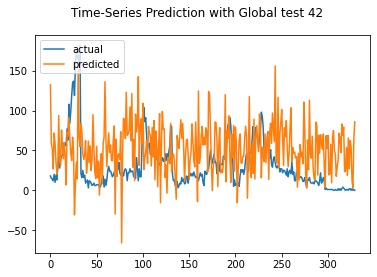

Test MAE: 50.431
Test RMSE: 59.757
Test sMAPE: 104.604
Test R Squared: -2.695
{'mae': 50.431364970134965, 'rmse': 59.75657363021902, 'smape': 104.6040491362082, 'r2': -2.6949909315608402}


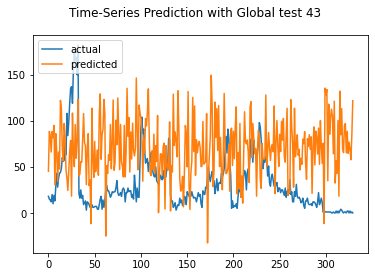

Test MAE: 43.352
Test RMSE: 51.259
Test sMAPE: 100.943
Test R Squared: -1.719
{'mae': 43.35169949892796, 'rmse': 51.258528537072934, 'smape': 100.94347046721154, 'r2': -1.718781282800649}


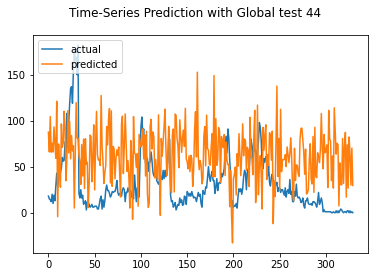

Test MAE: 52.870
Test RMSE: 62.461
Test sMAPE: 107.550
Test R Squared: -3.037
{'mae': 52.869549535260056, 'rmse': 62.46115688614755, 'smape': 107.54983864529892, 'r2': -3.037030674697716}


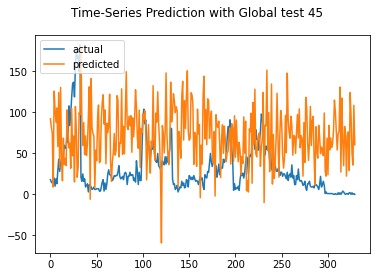

Test MAE: 72.600
Test RMSE: 81.047
Test sMAPE: 117.624
Test R Squared: -5.797
{'mae': 72.60036821365357, 'rmse': 81.0470022139286, 'smape': 117.62363127236401, 'r2': -5.796978764057184}


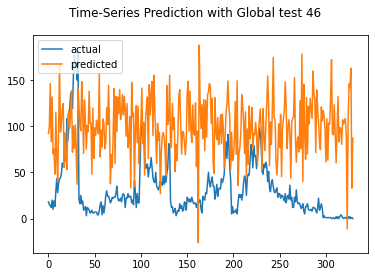

Test MAE: 53.743
Test RMSE: 63.212
Test sMAPE: 108.793
Test R Squared: -3.135
{'mae': 53.74252385677713, 'rmse': 63.21235502989522, 'smape': 108.79316609914022, 'r2': -3.1347184589918333}


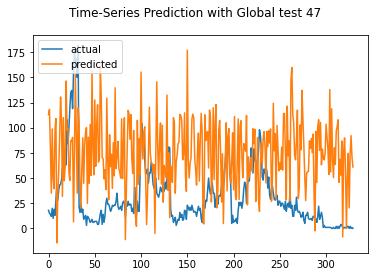

Test MAE: 34.916
Test RMSE: 45.093
Test sMAPE: 98.227
Test R Squared: -1.104
{'mae': 34.91646038618955, 'rmse': 45.09287027052748, 'smape': 98.22681069250824, 'r2': -1.1040582641249488}


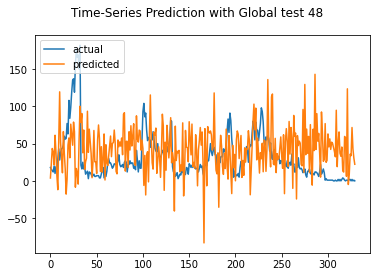

Test MAE: 39.714
Test RMSE: 48.511
Test sMAPE: 96.385
Test R Squared: -1.435
{'mae': 39.71360886295636, 'rmse': 48.511130107801996, 'smape': 96.38470614210824, 'r2': -1.4351447723910433}


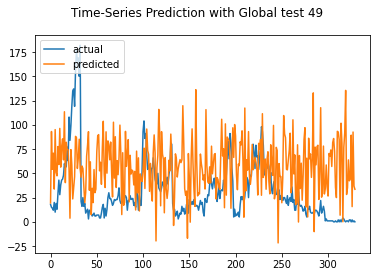

Test MAE: 55.168
Test RMSE: 63.278
Test sMAPE: 109.493
Test R Squared: -3.143
{'mae': 55.167967253562175, 'rmse': 63.27787519621583, 'smape': 109.49296445076631, 'r2': -3.143294245797306}


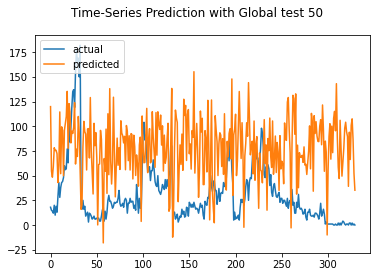

Test MAE: 64.986
Test RMSE: 74.338
Test sMAPE: 113.699
Test R Squared: -4.718
{'mae': 64.98605334108527, 'rmse': 74.33818436412835, 'smape': 113.69907983923606, 'r2': -4.718286371659012}


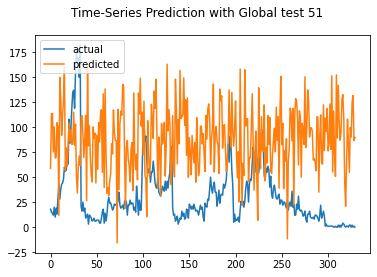

Test MAE: 35.570
Test RMSE: 45.055
Test sMAPE: 110.813
Test R Squared: -1.101
{'mae': 35.56966254115105, 'rmse': 45.05516837343765, 'smape': 110.81270734215222, 'r2': -1.10054135223873}


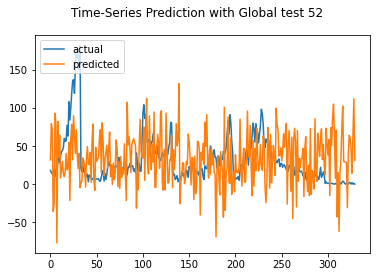

Test MAE: 35.775
Test RMSE: 44.471
Test sMAPE: 100.847
Test R Squared: -1.046
{'mae': 35.7751938458645, 'rmse': 44.470818584635275, 'smape': 100.84695284670002, 'r2': -1.0464081135896675}


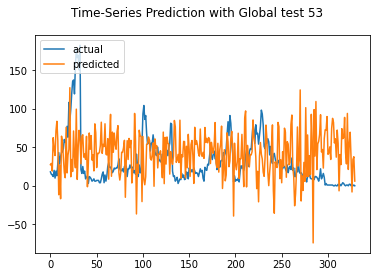

Test MAE: 53.987
Test RMSE: 64.032
Test sMAPE: 109.738
Test R Squared: -3.243
{'mae': 53.98695792032011, 'rmse': 64.03187020168252, 'smape': 109.7381390377527, 'r2': -3.2426223440156132}


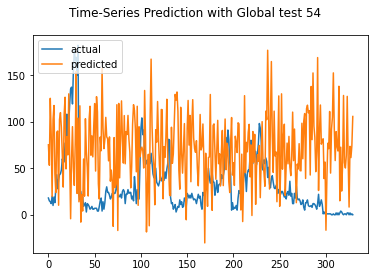

Test MAE: 49.984
Test RMSE: 58.615
Test sMAPE: 103.622
Test R Squared: -2.555
{'mae': 49.98392012209603, 'rmse': 58.61541805209461, 'smape': 103.62208742501711, 'r2': -2.555213899690844}


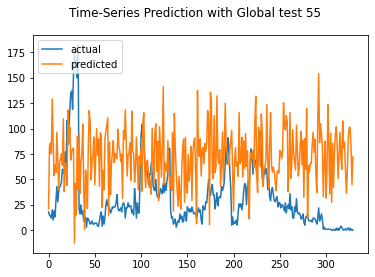

Test MAE: 52.066
Test RMSE: 61.059
Test sMAPE: 107.398
Test R Squared: -2.858
{'mae': 52.066472350106096, 'rmse': 61.058661358768944, 'smape': 107.3978833680517, 'r2': -2.8577720209281225}


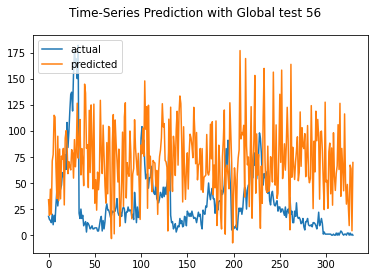

Test MAE: 42.293
Test RMSE: 52.315
Test sMAPE: 103.993
Test R Squared: -1.832
{'mae': 42.29264844348936, 'rmse': 52.314639557282874, 'smape': 103.99327516104782, 'r2': -1.8319688789786799}


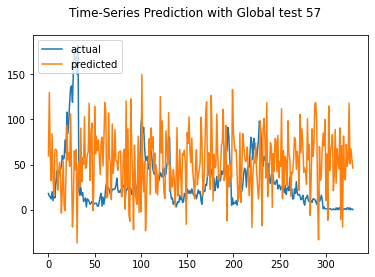

Test MAE: 51.008
Test RMSE: 59.903
Test sMAPE: 109.535
Test R Squared: -2.713
{'mae': 51.00822336962729, 'rmse': 59.903420683307594, 'smape': 109.5352887840965, 'r2': -2.713173541204241}


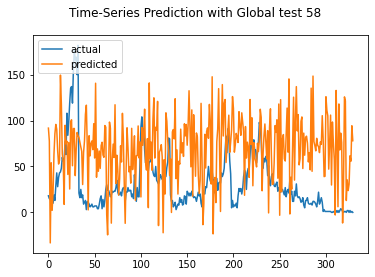

Test MAE: 41.957
Test RMSE: 51.582
Test sMAPE: 101.672
Test R Squared: -1.753
{'mae': 41.957436096307006, 'rmse': 51.581962825001554, 'smape': 101.67203018659025, 'r2': -1.753199803706332}


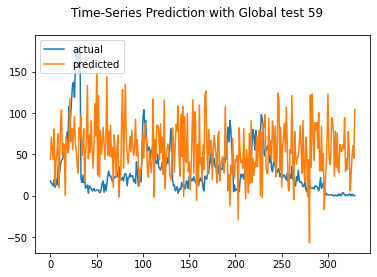

Test MAE: 38.932
Test RMSE: 48.549
Test sMAPE: 101.903
Test R Squared: -1.439
{'mae': 38.93243246006243, 'rmse': 48.54938611719245, 'smape': 101.90320288435352, 'r2': -1.438987010399607}


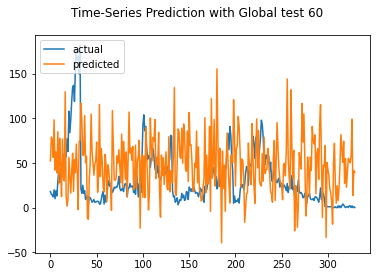

Test MAE: 40.257
Test RMSE: 49.233
Test sMAPE: 97.997
Test R Squared: -1.508
{'mae': 40.25716938773791, 'rmse': 49.23267876569975, 'smape': 97.9965873901257, 'r2': -1.5081236002082572}


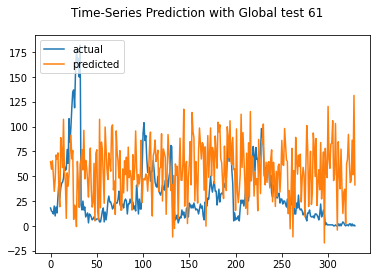

Test MAE: 43.474
Test RMSE: 54.567
Test sMAPE: 101.054
Test R Squared: -2.081
{'mae': 43.47391767808885, 'rmse': 54.56699275974112, 'smape': 101.05426584625847, 'r2': -2.08107338001955}


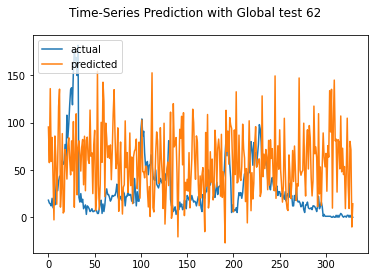

Test MAE: 34.848
Test RMSE: 44.127
Test sMAPE: 104.547
Test R Squared: -1.015
{'mae': 34.848035516883385, 'rmse': 44.12715826457942, 'smape': 104.54707252919135, 'r2': -1.0149019737203382}


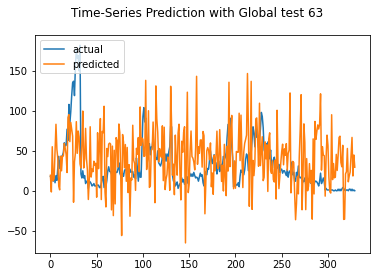

Test MAE: 47.966
Test RMSE: 57.025
Test sMAPE: 104.109
Test R Squared: -2.365
{'mae': 47.96556163701144, 'rmse': 57.02487477238298, 'smape': 104.10892067147637, 'r2': -2.3648885329026075}


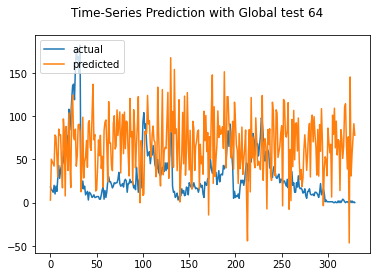

Test MAE: 60.630
Test RMSE: 69.696
Test sMAPE: 110.114
Test R Squared: -4.026
{'mae': 60.62983661131425, 'rmse': 69.69641780190545, 'smape': 110.11441671423015, 'r2': -4.026467929957733}


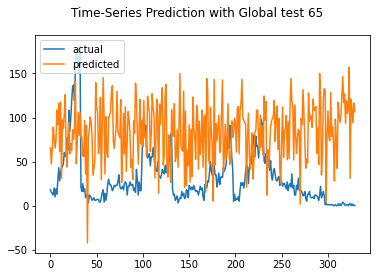

Test MAE: 65.125
Test RMSE: 74.712
Test sMAPE: 113.772
Test R Squared: -4.776
{'mae': 65.12458533734986, 'rmse': 74.71207146862506, 'smape': 113.7717108736552, 'r2': -4.77595175904674}


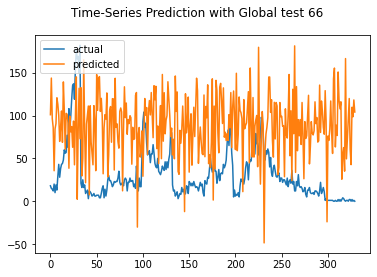

Test MAE: 75.315
Test RMSE: 85.800
Test sMAPE: 118.803
Test R Squared: -6.618
{'mae': 75.3152652350339, 'rmse': 85.8000010204234, 'smape': 118.80320548808444, 'r2': -6.617572349040844}


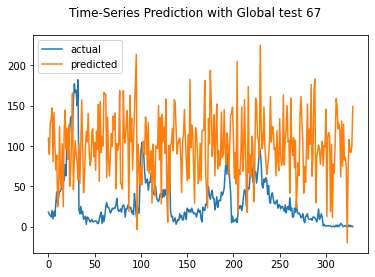

Test MAE: 41.174
Test RMSE: 49.423
Test sMAPE: 103.738
Test R Squared: -1.528
{'mae': 41.17400084463033, 'rmse': 49.423001691217884, 'smape': 103.73782650337688, 'r2': -1.52755281291279}


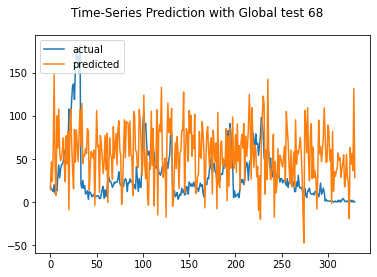

Test MAE: 42.174
Test RMSE: 51.473
Test sMAPE: 97.182
Test R Squared: -1.742
{'mae': 42.17404959003131, 'rmse': 51.472693983150556, 'smape': 97.18165319693895, 'r2': -1.7415476564897086}


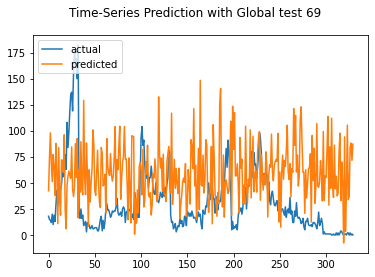

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 51.852
Test RMSE: 62.921
Test sMAPE: 108.187
Test R Squared: -3.097
{'mae': 51.85177134329622, 'rmse': 62.920640960045915, 'smape': 108.18682225362456, 'r2': -3.096644495466519}


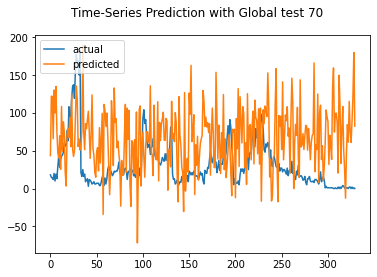

Test MAE: 37.805
Test RMSE: 49.159
Test sMAPE: 120.743
Test R Squared: -1.501
{'mae': 37.805271763422276, 'rmse': 49.159046863041176, 'smape': 120.74285415519623, 'r2': -1.500626961138769}


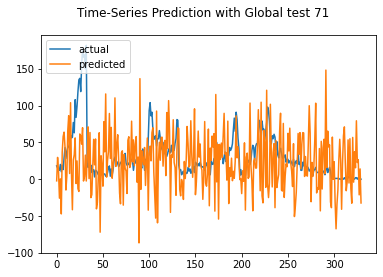

Test MAE: 44.979
Test RMSE: 57.516
Test sMAPE: 106.148
Test R Squared: -2.423
{'mae': 44.97851852846868, 'rmse': 57.51617551310263, 'smape': 106.14810642636695, 'r2': -2.4231190412711325}


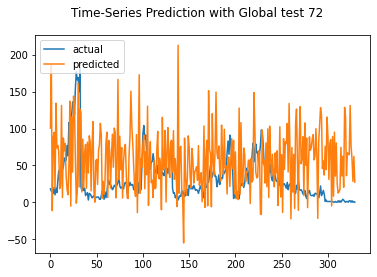

Test MAE: 44.895
Test RMSE: 54.283
Test sMAPE: 104.927
Test R Squared: -2.049
{'mae': 44.895191648873414, 'rmse': 54.28305648104611, 'smape': 104.92742243090906, 'r2': -2.0490924184419295}


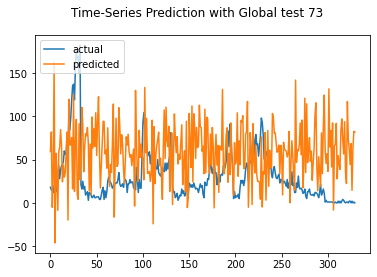

Test MAE: 69.687
Test RMSE: 77.750
Test sMAPE: 116.335
Test R Squared: -5.255
{'mae': 69.68683172572743, 'rmse': 77.7498745451924, 'smape': 116.33482109002524, 'r2': -5.255202814553763}


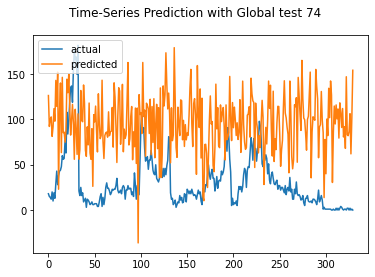

Test MAE: 45.952
Test RMSE: 55.261
Test sMAPE: 103.548
Test R Squared: -2.160
{'mae': 45.952203169555375, 'rmse': 55.2607382354067, 'smape': 103.54803964881917, 'r2': -2.1599147526621807}


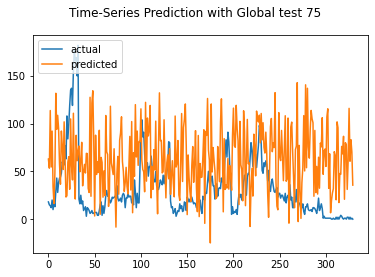

Test MAE: 46.329
Test RMSE: 54.637
Test sMAPE: 100.879
Test R Squared: -2.089
{'mae': 46.32911530769233, 'rmse': 54.63668568603215, 'smape': 100.87910780901342, 'r2': -2.0889486956630807}


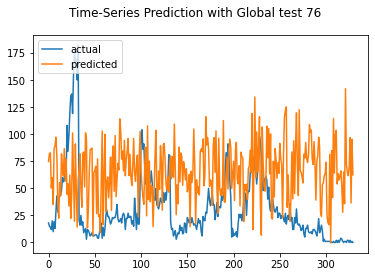

Test MAE: 37.870
Test RMSE: 47.013
Test sMAPE: 96.431
Test R Squared: -1.287
{'mae': 37.87047581040498, 'rmse': 47.01330290904491, 'smape': 96.43124099735387, 'r2': -1.2870914413894692}


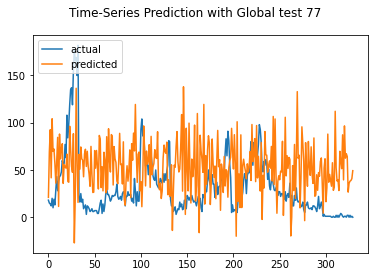

Test MAE: 43.558
Test RMSE: 54.023
Test sMAPE: 100.875
Test R Squared: -2.020
{'mae': 43.558442529945665, 'rmse': 54.02321179899371, 'smape': 100.87505822286218, 'r2': -2.019971207710481}


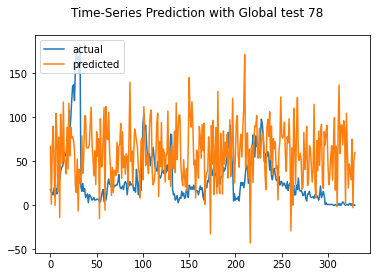

Test MAE: 40.684
Test RMSE: 50.226
Test sMAPE: 108.669
Test R Squared: -1.610
{'mae': 40.68366300879103, 'rmse': 50.22609121565275, 'smape': 108.66923035880609, 'r2': -1.6103621508311297}


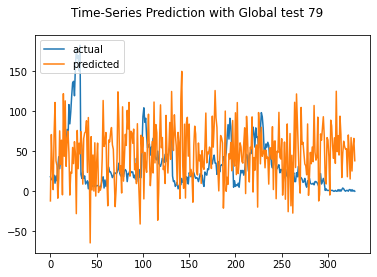

Test MAE: 46.657
Test RMSE: 56.650
Test sMAPE: 104.225
Test R Squared: -2.321
{'mae': 46.657485077056016, 'rmse': 56.650212363343435, 'smape': 104.22452354073792, 'r2': -2.3208180896382498}


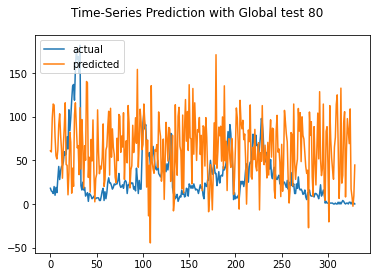

Test MAE: 63.306
Test RMSE: 70.982
Test sMAPE: 112.813
Test R Squared: -4.214
{'mae': 63.306280667854075, 'rmse': 70.98243036278791, 'smape': 112.81284652834262, 'r2': -4.213672314393376}


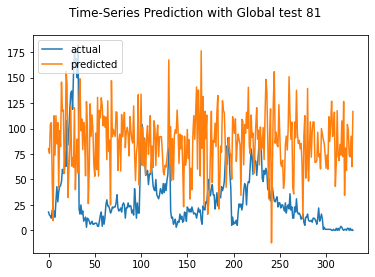

Test MAE: 49.153
Test RMSE: 57.194
Test sMAPE: 104.825
Test R Squared: -2.385
{'mae': 49.15304748587536, 'rmse': 57.19360967802628, 'smape': 104.8252521952794, 'r2': -2.384831204053244}


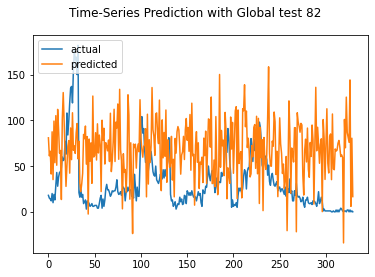

Test MAE: 50.462
Test RMSE: 59.330
Test sMAPE: 106.159
Test R Squared: -2.642
{'mae': 50.46162482807131, 'rmse': 59.330002136962314, 'smape': 106.15878438172724, 'r2': -2.642425935213974}


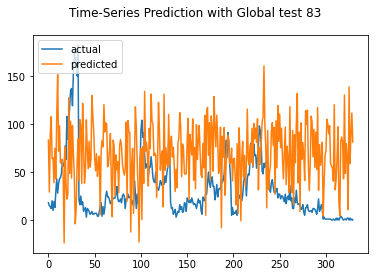

Test MAE: 42.941
Test RMSE: 54.348
Test sMAPE: 101.460
Test R Squared: -2.056
{'mae': 42.94078879374447, 'rmse': 54.34773917547323, 'smape': 101.45967728599494, 'r2': -2.05636323294411}


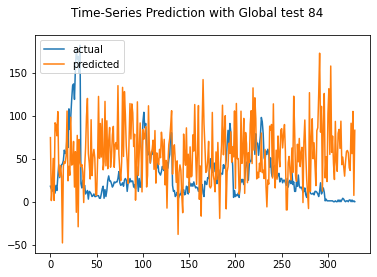

Test MAE: 58.866
Test RMSE: 67.526
Test sMAPE: 110.567
Test R Squared: -3.718
{'mae': 58.86624610351794, 'rmse': 67.52631793182931, 'smape': 110.5665084060181, 'r2': -3.7183281302160163}


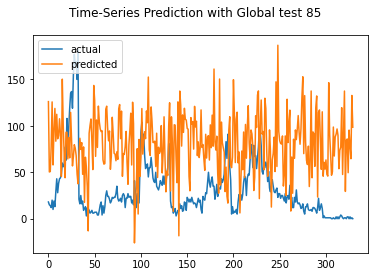

Test MAE: 42.142
Test RMSE: 50.532
Test sMAPE: 98.654
Test R Squared: -1.642
{'mae': 42.14201238299861, 'rmse': 50.53210808401421, 'smape': 98.65416140086029, 'r2': -1.6422678132310757}


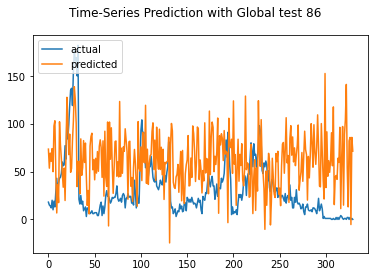

Test MAE: 52.089
Test RMSE: 61.372
Test sMAPE: 105.184
Test R Squared: -2.897
{'mae': 52.089486839554525, 'rmse': 61.371787508660546, 'smape': 105.18445891084464, 'r2': -2.8974409778910775}


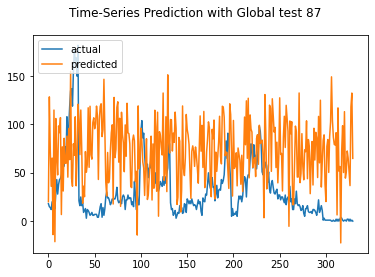

Test MAE: 53.254
Test RMSE: 62.817
Test sMAPE: 108.890
Test R Squared: -3.083
{'mae': 53.25365018212434, 'rmse': 62.81739439371277, 'smape': 108.89030939782467, 'r2': -3.0832111467370877}


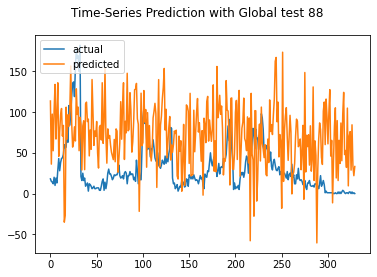

Test MAE: 38.252
Test RMSE: 49.026
Test sMAPE: 103.467
Test R Squared: -1.487
{'mae': 38.25163966092197, 'rmse': 49.025906474446096, 'smape': 103.46743786527853, 'r2': -1.4871001084671907}


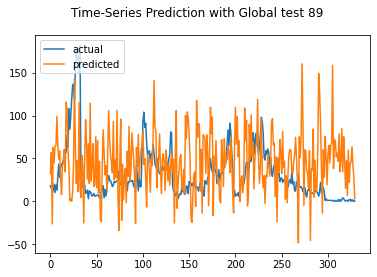

Test MAE: 61.430
Test RMSE: 71.837
Test sMAPE: 112.947
Test R Squared: -4.340
{'mae': 61.430473773407215, 'rmse': 71.8372073397962, 'smape': 112.9470440328991, 'r2': -4.339995405675466}


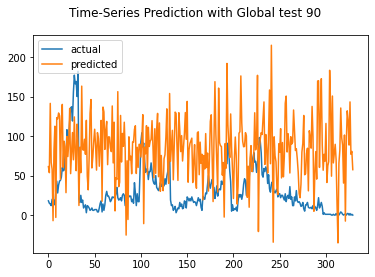

Test MAE: 34.130
Test RMSE: 45.903
Test sMAPE: 114.315
Test R Squared: -1.180
{'mae': 34.129932482495455, 'rmse': 45.903153390150806, 'smape': 114.3145500626991, 'r2': -1.1803541654775436}


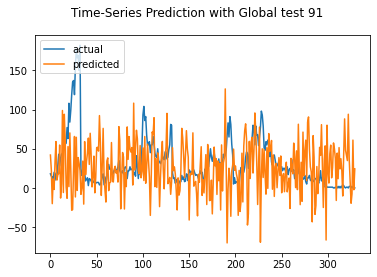

Test MAE: 54.541
Test RMSE: 63.551
Test sMAPE: 108.767
Test R Squared: -3.179
{'mae': 54.540946393301994, 'rmse': 63.55055930486501, 'smape': 108.76662798121782, 'r2': -3.1790806829290847}


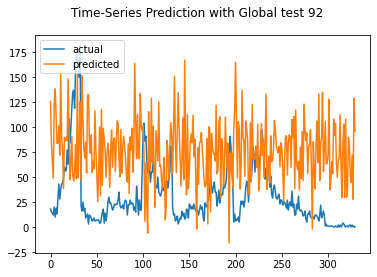

Test MAE: 63.324
Test RMSE: 72.106
Test sMAPE: 111.847
Test R Squared: -4.380
{'mae': 63.323567084110145, 'rmse': 72.10619041228931, 'smape': 111.84732277734354, 'r2': -4.380059811066945}


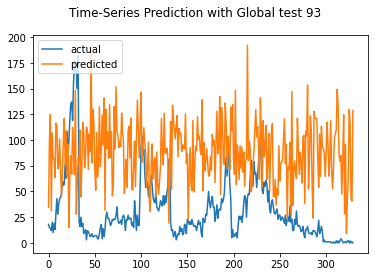

Test MAE: 43.914
Test RMSE: 53.883
Test sMAPE: 104.752
Test R Squared: -2.004
{'mae': 43.913568844036625, 'rmse': 53.88315034707381, 'smape': 104.75247507669792, 'r2': -2.0043322546146785}


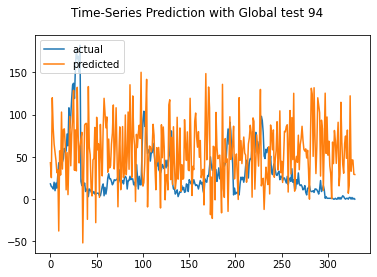

Test MAE: 51.460
Test RMSE: 61.212
Test sMAPE: 105.008
Test R Squared: -2.877
{'mae': 51.459728279980745, 'rmse': 61.211873154542715, 'smape': 105.008380780277, 'r2': -2.8771565839497835}


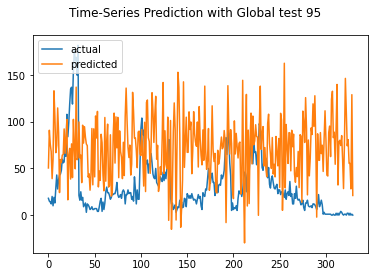

Test MAE: 62.552
Test RMSE: 70.266
Test sMAPE: 114.482
Test R Squared: -4.109
{'mae': 62.55172495336244, 'rmse': 70.26591922807471, 'smape': 114.48224479135308, 'r2': -4.108947806685291}


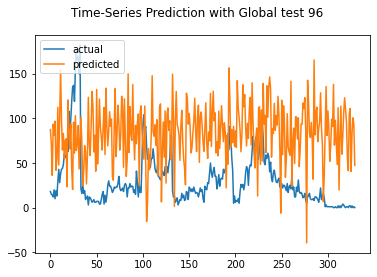

Test MAE: 58.451
Test RMSE: 67.853
Test sMAPE: 110.757
Test R Squared: -3.764
{'mae': 58.45068098451152, 'rmse': 67.85264528660284, 'smape': 110.75673641480248, 'r2': -3.764041860966449}


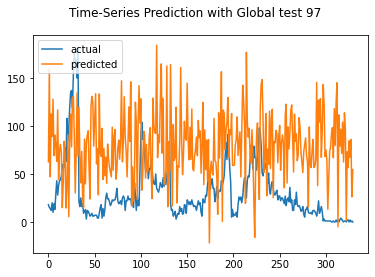

Test MAE: 44.750
Test RMSE: 54.004
Test sMAPE: 104.004
Test R Squared: -2.018
{'mae': 44.74992946747577, 'rmse': 54.00385442731678, 'smape': 104.00398260010816, 'r2': -2.017807388498874}


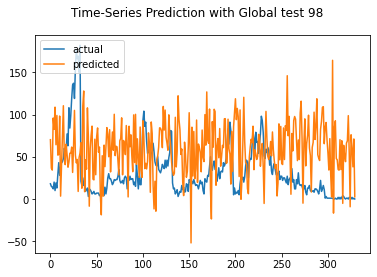

Test MAE: 39.092
Test RMSE: 48.113
Test sMAPE: 97.103
Test R Squared: -1.395
{'mae': 39.0921549141407, 'rmse': 48.112849676567734, 'smape': 97.10274693828464, 'r2': -1.3953234304037614}


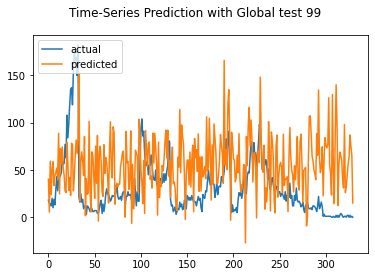

rmse : average=56.549, std=8.865
mae : average=47.054, std=9.058
smape : average=106.038, std=5.220
r2 : average=-2.390, std=1.110


([56.54871697620814, 8.865004239604431],
 [47.05356445192567, 9.057653503424506],
 [106.03839661693102, 5.220198270367267],
 [-2.3902499652638833, 1.1099247419901228])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')